In [1]:
from astropy.io import fits
import glob
from astropy.io import ascii
import os
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
datadir = '/n/holyscratch01/conroy_lab/vchandra/mage/'
#datadir = '/n/holystore01/LABS/conroy_lab/Lab/vchandra/mage/'

In [3]:
allnights = glob.glob(datadir + 'data/*')

In [4]:
nights = [];
for path in allnights:
    night = os.path.basename(path)

    if 'b' not in night and '202' in night:
        nights.append(night)

nights = np.sort(nights)

In [5]:
nights

array(['2022_08_03', '2022_08_04', '2022_08_05', '2022_08_24',
       '2022_10_21', '2022_11_03', '2022_12_18', '2022_12_19',
       '2023_01_29', '2023_02_07', '2023_02_08', '2023_03_06',
       '2023_03_12', '2023_03_28', '2023_04_29', '2023_04_30',
       '2023_05_29', '2023_06_11', '2023_08_16', '2023_10_13',
       '2023_11_05', '2023_12_03', '2023_12_12', '2023_12_20',
       '2024_02_25', '2024_03_18'], dtype='<U10')

In [6]:
rows = [];

for night in nights:

    print('==' * 10)
    print(night)
    ndir = datadir + 'data/' + night + '/'
    obslog = ascii.read(ndir + 'raw/obslog_edited.txt', format = 'fixed_width')
    sci = obslog['frametype'] == 'science'
    scitargets = np.unique(obslog['target'][sci])
    N_sci = len(scitargets)
    coadds = glob.glob(ndir + 'reduced_v0/magellan_mage_A/Science/coadd/*fits')
    coadd_names = [path.split('/')[-1].split('_')[0] for path in coadds]
    N_coadd = len(coadds)
    print('there are %i unique science targets and %i coadded spectra' % (N_sci, N_coadd))
    for target in scitargets:
        if target not in coadd_names:
            print('%s is a science target without a reduced, coadded spectrum!' % target)

    N_missing = N_sci - N_coadd

    out = {};

    out['night'] = night
    out['N_sci'] = N_sci
    out['N_coadd'] = N_coadd
    out['N_missing'] = N_missing

    rows.append(out)

2022_08_03
there are 21 unique science targets and 18 coadded spectra
j2045m1858 is a science target without a reduced, coadded spectrum!
j2224p0647 is a science target without a reduced, coadded spectrum!
j2334m2043 is a science target without a reduced, coadded spectrum!
2022_08_04
there are 25 unique science targets and 25 coadded spectra
2022_08_05
there are 17 unique science targets and 16 coadded spectra
j2203p0725 is a science target without a reduced, coadded spectrum!
2022_08_24
there are 22 unique science targets and 22 coadded spectra
2022_10_21
there are 21 unique science targets and 21 coadded spectra
2022_11_03
there are 31 unique science targets and 29 coadded spectra
j0501m0512 is a science target without a reduced, coadded spectrum!
j2312m6922 is a science target without a reduced, coadded spectrum!
2022_12_18
there are 26 unique science targets and 0 coadded spectra
hip108327 is a science target without a reduced, coadded spectrum!
hip109822 is a science target withou

In [7]:
tab = Table(rows)

In [10]:
np.sum(tab['N_coadd'])

542

Text(0, 0.5, 'fraction missing')

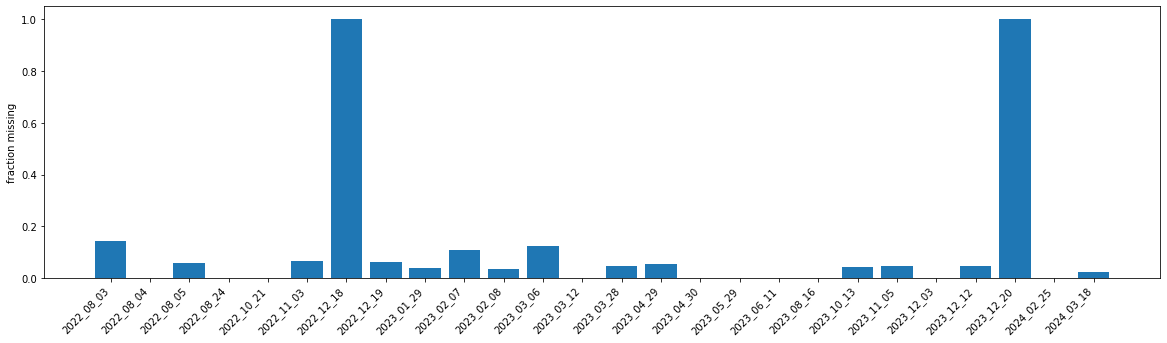

In [8]:
plt.figure(figsize = (20, 5))
plt.bar(tab['night'], tab['N_missing'] / tab['N_sci'])
plt.xticks(rotation = 45,  ha = 'right');
plt.ylabel('fraction missing')

## Check Sensitivity Functions

In [15]:
import pprint
import numpy.lib.recfunctions as rfn

In [16]:
#sensfile = datadir + 'data/%s/reduced_v0/magellan_mage_A/Science/sensfunc.fits' % night
stdfile = '/n/holyscratch01/conroy_lab/vchandra/mage/data/2022_12_18/reduced_v0/magellan_mage_A/Science/spec1d_mage0063-hip108327_MagE_20221219T002909.000.fits'

In [17]:
import pandas as pd

In [18]:
with fits.open(stdfile, 'update') as f:
    for idx in range(len(f) - 1):
        idx += 1
        hdu = f[idx]

        print(hdu.header['EXTNAME'])

        if 'ORDER' not in hdu.header['EXTNAME']:
            print('not order')
            break
        
        names = list(hdu.data.names)

        if 'ORDER0006' in hdu.header["EXTNAME"]:

            print('WORKING ON ORDER %s' % hdu.header['EXTNAME'])

            boxnames = [(name.replace('BOX', '')) for name in names if 'BOX' in name]

            data = hdu.data.copy()

            data['BOX_MASK'] = np.repeat(True, len(data['BOX_MASK']))

            for bn in boxnames:
                
                if 'OPT' + bn in list(data.dtype.names):
                    print('opt in name')
                    data['OPT' + bn] = data['BOX' + bn]
                else:
                    print('opt not in name')
                    new = np.array(data['BOX' + bn], dtype=[('OPT' + bn, data['BOX' + bn].dtype)])
                    data = rfn.merge_arrays(data, new, asrecarray = True, flatten = True)
                    data = rfn.append_fields(data, new.dtype.names[0], data['BOX' + bn])

                    #
                    #break
                    #data = rfn.append_fields(data, 'OPT' + bn, data['BOX' + bn], dtypes = data['BOX' + bn].dtype)

            #df = pd.DataFrame(data).reindex()
            # print(np.sum(df['BOX_MASK']))
            # df['BOX_MASK'] = np.repeat(True, len(df['BOX_MASK']))
            # print(np.sum(df['BOX_MASK']))

            # for bn in boxnames:
            #     df['OPT' + bn] = df['BOX' + bn]
            #newdata = df.to_records()

            f[idx].data = data


OBJ0448-DET01-ORDER0017
OBJ0448-DET01-ORDER0016
OBJ0448-DET01-ORDER0015
OBJ0448-DET01-ORDER0014
OBJ0448-DET01-ORDER0013
OBJ0448-DET01-ORDER0012
OBJ0448-DET01-ORDER0011
OBJ0448-DET01-ORDER0010
OBJ0448-DET01-ORDER0009
OBJ0448-DET01-ORDER0008
OBJ0448-DET01-ORDER0007
OBJ0448-DET01-ORDER0006
WORKING ON ORDER OBJ0448-DET01-ORDER0006
opt in name
opt in name
opt in name
opt in name
opt in name
opt in name
opt in name
opt in name
opt in name
DET01-DETECTOR
not order


Check Bad Arc

In [19]:
fname = '/n/holyscratch01/conroy_lab/vchandra/mage/data/2023_12_20/raw/mage0062.fits'

In [20]:
f = fits.open(fname)

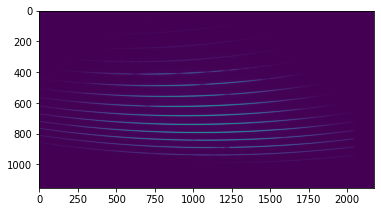

In [23]:
plt.imshow(np.log10(f[0].data))

masked_array(data=[(941.2587648309219, 2.44615361720269, 10.0, 9798.173572091599, 4423.360200341207, 0.00016692092224240406, 77.40065078226421, 0.000970962553801815, 84, 945.5634480767502, 9.815059439145417, 0, 10.0),
                   (941.368142176415, 2.4485210802657607, 10.0, 9796.391932926572, 4549.095423167725, 0.00017156266491285995, 76.34640788155345, 0.0010303423510252528, 84, 933.6579617957088, 9.44740732313448, 1, 10.0),
                   (941.4780595950938, 2.4528727258117664, 10.0, 9794.600761329824, 4210.441105919157, 0.00018532820031663452, 73.45633326639991, 0.0010509523648863951, 84, 911.7511140113268, 9.42188304788177, 2, 10.0),
                   ...,
                   (909.0388308969145, 2.9966975505329554, 10.0, 11024.222053962052, 1697.4598977241496, 8.774590308537543e-06, 337.58766984843237, 1.5530612932210123e-05, 84, 979.320530151533, 172.81389976645386, 2045, 10.0),
                   (908.8900399254314, 2.9967227324901287, 10.0, 11024.725319155319, 2251.62

In [14]:
f = fits.open(sensfile)

FileNotFoundError: [Errno 2] No such file or directory: '/n/holyscratch01/conroy_lab/vchandra/mage/data/2022_08_03/reduced_v0/magellan_mage_A/Science/sensfunc.fits'

In [19]:
data

array([(941.25876483, 2.44615362, 10.,  9798.17357209,  4423.36020034, 1.66920922e-04,   77.40065078, 9.70962554e-04, 84,  945.56344808,    9.81505944,    0),
       (941.36814218, 2.44852108, 10.,  9796.39193293,  4549.09542317, 1.71562665e-04,   76.34640788, 1.03034235e-03, 84,  933.6579618 ,    9.44740732,    1),
       (941.4780596 , 2.45287273, 10.,  9794.60076133,  4210.44110592, 1.85328200e-04,   73.45633327, 1.05095236e-03, 84,  911.75111401,    9.42188305,    2),
       ...,
       (909.0388309 , 2.99669755, 10., 11024.22205396,  1697.45989772, 8.77459031e-06,  337.58766985, 1.55306129e-05, 84,  979.32053015,  172.81389977, 2045),
       (908.89003993, 2.99672273, 10., 11024.72531916,  2251.62540748, 3.24333496e-06,  555.26985683, 5.80759833e-06, 84, 1104.19346231,  304.56166476, 2046),
       (908.741093  , 2.99674639, 10., 11025.22443775, 12147.61809053, 1.42336361e-07, 2650.58704858, 5.13230016e-07, 84, 1243.5932291 , 1248.62940368, 2047)],
      dtype=(numpy.record, [('TRA

In [38]:
night = '2022_11_03'

In [39]:
rawdir = datadir + 'data/' + night + '/raw/'

In [40]:
file = rawdir + 'mage1067.fits'

In [41]:
with fits.open(file, 'update') as f:
    print(f[0].header['OBJECT'])

None


In [42]:
with fits.open(file, 'update') as f:
    f[0].header['OBJECT'] = 'thar'

In [43]:
with fits.open(file) as f:
    print(f[0].header['OBJECT'])

thar
